**Matching**

Описание проекта
Matching - это задача поиска и сопоставления двух объектов из разных наборов данных. Такая потребность возникла у маркетплейса, который имеет большой перечен товаров для продажи. На склад стали поступать новые партии товаров, которые имеет небольшие отличия в характеристиках. Технически, это выглядит как совершенно новые товары. Фактически это те же товары, которые уже продаются на маркетплейсе. Задача сопоставить и связать новые товары со старыми, пользуясь совпадающими характеристиками.

**Что надо сделать?**

разработать алгоритм, который для всех товаров из validation.csv предложит несколько вариантов наиболее похожих товаров из base;
оценить качество алгоритма по метрике accuracy@5.
𝑎𝑐𝑐𝑢𝑟𝑎𝑐𝑦@𝑛=кол-во верных соотношений (из n кандидатов)n (общее кол-во кандидатов)∗100%
Именно в предложении 5 кандидатов для соотношения и заключается отличительная черта данной метрики.

Данные:

base.csv - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base, …) и вектор признаков размерностью 72.
train.csv - обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …) , вектор признаков И id товара из base.csv, который максимально похож на него (по мнению экспертов).
validation.csv - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из base.csv
validation_answer.csv - правильные ответы к предыдущему файлу.
План работы:

1. Загрузить данные
2. Понять задачу
3. Подготовить данные
4. Обучить модель (поиск ближайших соседей + ранжирование)
5. Измерить качество
6. git commit

Примечание: ячейки кода, исполнение которы занимает продолжительное время, имеют функцию %%time и время исполнения, указанное в конце выходных данных.



# Новый раздел

In [ ]:
!apt -q install libomp-dev
!pip -q install faiss-gpu

Reading package lists...
Building dependency tree...
Reading state information...
libomp-dev is already the newest version (1:14.0-55~exp2).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
pip install phik

In [ ]:
pip install optuna

In [ ]:
import gc
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np
import faiss
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tqdm.notebook import tqdm
import requests
import os
from urllib.parse import urlencode
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)



import requests
import os
import zipfile
import phik
from phik import phik_matrix
import optuna
from scipy.stats import randint
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.pyplot as plt

**Необходимые функции:**

In [ ]:

def optimize_memory_usage(df: pd.DataFrame, print_size: bool=True) -> pd.DataFrame:

    '''
    Function optimizes memory usage in dataframe
    print_size: bool - display of optimization results
    return pd.DataFrame - amount of optimized memory
    '''

    # Типы, которые будем проверять на оптимизацию
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

    # Размер занимаемой памяти до оптимизации (в Мб)
    before_size = df.memory_usage().sum() / 1024**2
    for column in df.columns:
        column_type = df[column].dtypes
        if column_type in numerics:
            column_min = df[column].min()
            column_max = df[column].max()
            if str(column_type).startswith('int'):
                if column_min > np.iinfo(np.int8).min and column_max < np.iinfo(np.int8).max:
                    df[column] = df[column].astype(np.int8)
                elif column_min > np.iinfo(np.int16).min and column_max < np.iinfo(np.int16).max:
                    df[column] = df[column].astype(np.int16)
                elif column_min > np.iinfo(np.int32).min and column_max < np.iinfo(np.int32).max:
                    df[column] = df[column].astype(np.int32)
                elif column_min > np.iinfo(np.int64).min and column_max < np.iinfo(np.int64).max:
                    df[column] = df[column].astype(np.int64)
            else:
                if column_min > np.finfo(np.float32).min and column_max < np.finfo(np.float32).max:
                    df[column] = df[column].astype(np.float32)
                else:
                    df[column] = df[column].astype(np.float64)

    # Размер занимаемой памяти после оптимизации (в Мб)
    after_size = df.memory_usage().sum() / 1024**2
    if print_size: print('Размер использования памяти: до {:5.2f} Mb - после {:5.2f} Mb ({:.1%})'
                        .format(before_size, after_size, (before_size - after_size) / before_size))

    return df

In [ ]:
def set_frame_style(df, caption=""):
    """Helper function to set dataframe presentation style.
    """
    return df.style.background_gradient(cmap='Blues').set_caption(caption).set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'Blue'),
        ('font-size', '18px'),
        ('font-weight','bold')
    ]}])

def check_data(data, title):
    cols = data.columns.to_list()
    display(set_frame_style(data[cols].head(),f'{title}: First 5 Rows Of Data'))
    display(set_frame_style(data[cols].describe(),f'{title}: Summary Statistics'))
    display(set_frame_style(data[cols].nunique().to_frame().rename({0:'Unique Value Count'}, axis=1).transpose(), f'{title}: Unique Value Counts In Each Column'))
    display(set_frame_style(data[cols].isna().sum().to_frame().transpose(), f'{title}:Columns With Nan'))

In [ ]:
def show_graph_matrix_(dataframe: pd.DataFrame, color='blue', x=6, y=12):
    fig, axs = plt.subplots(y, x, figsize=(x * 4, y * 4))
    jx = 0  # Накопитель для номера колонки

    for i in range(y):
        for j in range(x):
            column = str(i + j + jx)
            if column in dataframe.columns:  # Проверка, существует ли колонка
                axs[i, j].hist(dataframe[column], color=color, bins=20, density=True)  # Построение гистограммы с плотностью
                axs[i, j].set_title(f'Гистограмма признака №{column}')

                # Вычисление квантилей и выбросов
                lower_quantile_value = dataframe[column].quantile(0.01)
                upper_quantile_value = dataframe[column].quantile(0.99)
                outliers = dataframe[(dataframe[column] < lower_quantile_value) | (dataframe[column] > upper_quantile_value)]
                outliers_percentage = len(outliers) / len(dataframe) * 100

                axs[i, j].set_xlabel('Значения', fontsize=12)
                axs[i, j].set_ylabel('Частота', fontsize=12)
                axs[i, j].set_title(f'Гистограмма признака №{column}\nВыбросы: {outliers_percentage:.2f}%')
            else:
                axs[i, j].axis('off')  # Отключение оси для несуществующих колонок

        jx += 5

    plt.tight_layout()  # Настройка для предотвращения перекрытия подписей
    plt.show()

In [ ]:
import requests
import zipfile
from urllib.parse import urlencode
import os

def downloader(size: str='small'):
    if size not in ['small', 'large']:
        raise Exception('Unknown Argument')
    elif size == 'small':
        public_key = 'https://disk.yandex.ru/d/W6Pt3R8RAwRPvA'
        file_prefix = 'small_'
    else:
        public_key = 'https://disk.yandex.ru/d/BBEphK0EHSJ5Jw'
        file_prefix = 'large_'

    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']

    download_response = requests.get(download_url)

    os.makedirs(f'/content/{file_prefix}data', exist_ok=True)

    with open(f'/content/{file_prefix}data/data.zip', 'wb') as f:
        f.write(download_response.content)

    zip_path = f'/content/{file_prefix}data/data.zip'

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(f'/content/{file_prefix}data')

In [ ]:
%%time
downloader('large')
base_df_large = pd.read_csv("/content/large_data/base.csv", index_col=0)
train_df_large = pd.read_csv("/content/large_data/train.csv", index_col=0)
valid_df_large = pd.read_csv("/content/large_data/validation.csv", index_col=0)
valid_targets_large = pd.read_csv("/content/large_data/validation_answer.csv", index_col=0)

CPU times: user 1min 34s, sys: 18.9 s, total: 1min 53s
Wall time: 3min 5s


In [ ]:
base_df_large = pd.read_csv("/content/large_data/base.csv", index_col=0)
train_df_large = pd.read_csv("/content/large_data/train.csv", index_col=0)
valid_df_large = pd.read_csv("/content/large_data/validation.csv", index_col=0)
valid_targets_large = pd.read_csv("/content/large_data/validation_answer.csv", index_col=0)

In [ ]:
%%time
downloader('small')
base_df       = pd.read_csv("/content/small_data/base_small.csv", index_col=0)
train_df      = pd.read_csv('/content/small_data/train_small.csv', index_col=0)
valid_df      = pd.read_csv('/content/small_data/validation_small.csv', index_col=0)
valid_targets = pd.read_csv('/content/small_data/anser_smal.csv', index_col=0)

CPU times: user 9.55 s, sys: 785 ms, total: 10.3 s
Wall time: 23.1 s


In [ ]:
%%time
base_df       = pd.read_csv("/content/small_data/base_small.csv", index_col=0)
train_df      = pd.read_csv('/content/small_data/train_small.csv', index_col=0)
valid_df      = pd.read_csv('/content/small_data/validation_small.csv', index_col=0)
valid_targets = pd.read_csv('/content/small_data/anser_smal.csv', index_col=0)

In [ ]:
# стандартизация названий колонок, смена индексации и оптимизации объёма данных
for df in [base_df_large, train_df_large, valid_df_large, valid_targets_large]:
    df.columns = df.columns.str.lower()
    df = optimize_memory_usage(df)
del df

**Анализ данных**

Base - набор из всех товаров (когда либо продававшихся на маркетплейсе) и 71 колонки с их характеристиками. Фактическое значение этих характеристик не имеет значения в рамках этого проекта. Эти данные прошли предварительную обработку (анонимизацию). По этой причине значения выглядят совершенно абстрактными на первый взгляд

In [ ]:
%%time
check_data(base_df_large, 'Весь набор данных')
print('Кол-во товаров-дубликатов:', base_df_large.duplicated().sum())
base_df_large.info()

Train - набор из товаров новых поставок, для которых известны соответствующие товары из "старого" датасета base. ID этого товара содержится в отдельном датасете target.

In [ ]:
%%time
check_data(train_df_large, 'Train')
print('Кол-во товаров-дубликатов:', train_df_large.duplicated().sum())
train_df_large.info()

`Valid` - набор из товаров новых поставок, для которых НЕ известны соответствующие товары и их необходимо найти.

In [ ]:
%%time
check_data(valid_df_large, 'Test')
print('Кол-во товаров-дубликатов:', valid_df_large.duplicated().sum())
valid_df_large.info()

`Valid_answer` - верные соответствующие товары для выборки Valid. Необходимо для тестирования обученной модели.

In [ ]:
%%time
check_data(valid_targets_large, 'valid_targets')
print('Кол-во товаров-дубликатов:', valid_targets_large.duplicated().sum())
valid_targets_large.info()

Посмотрим как распределены наши признаки

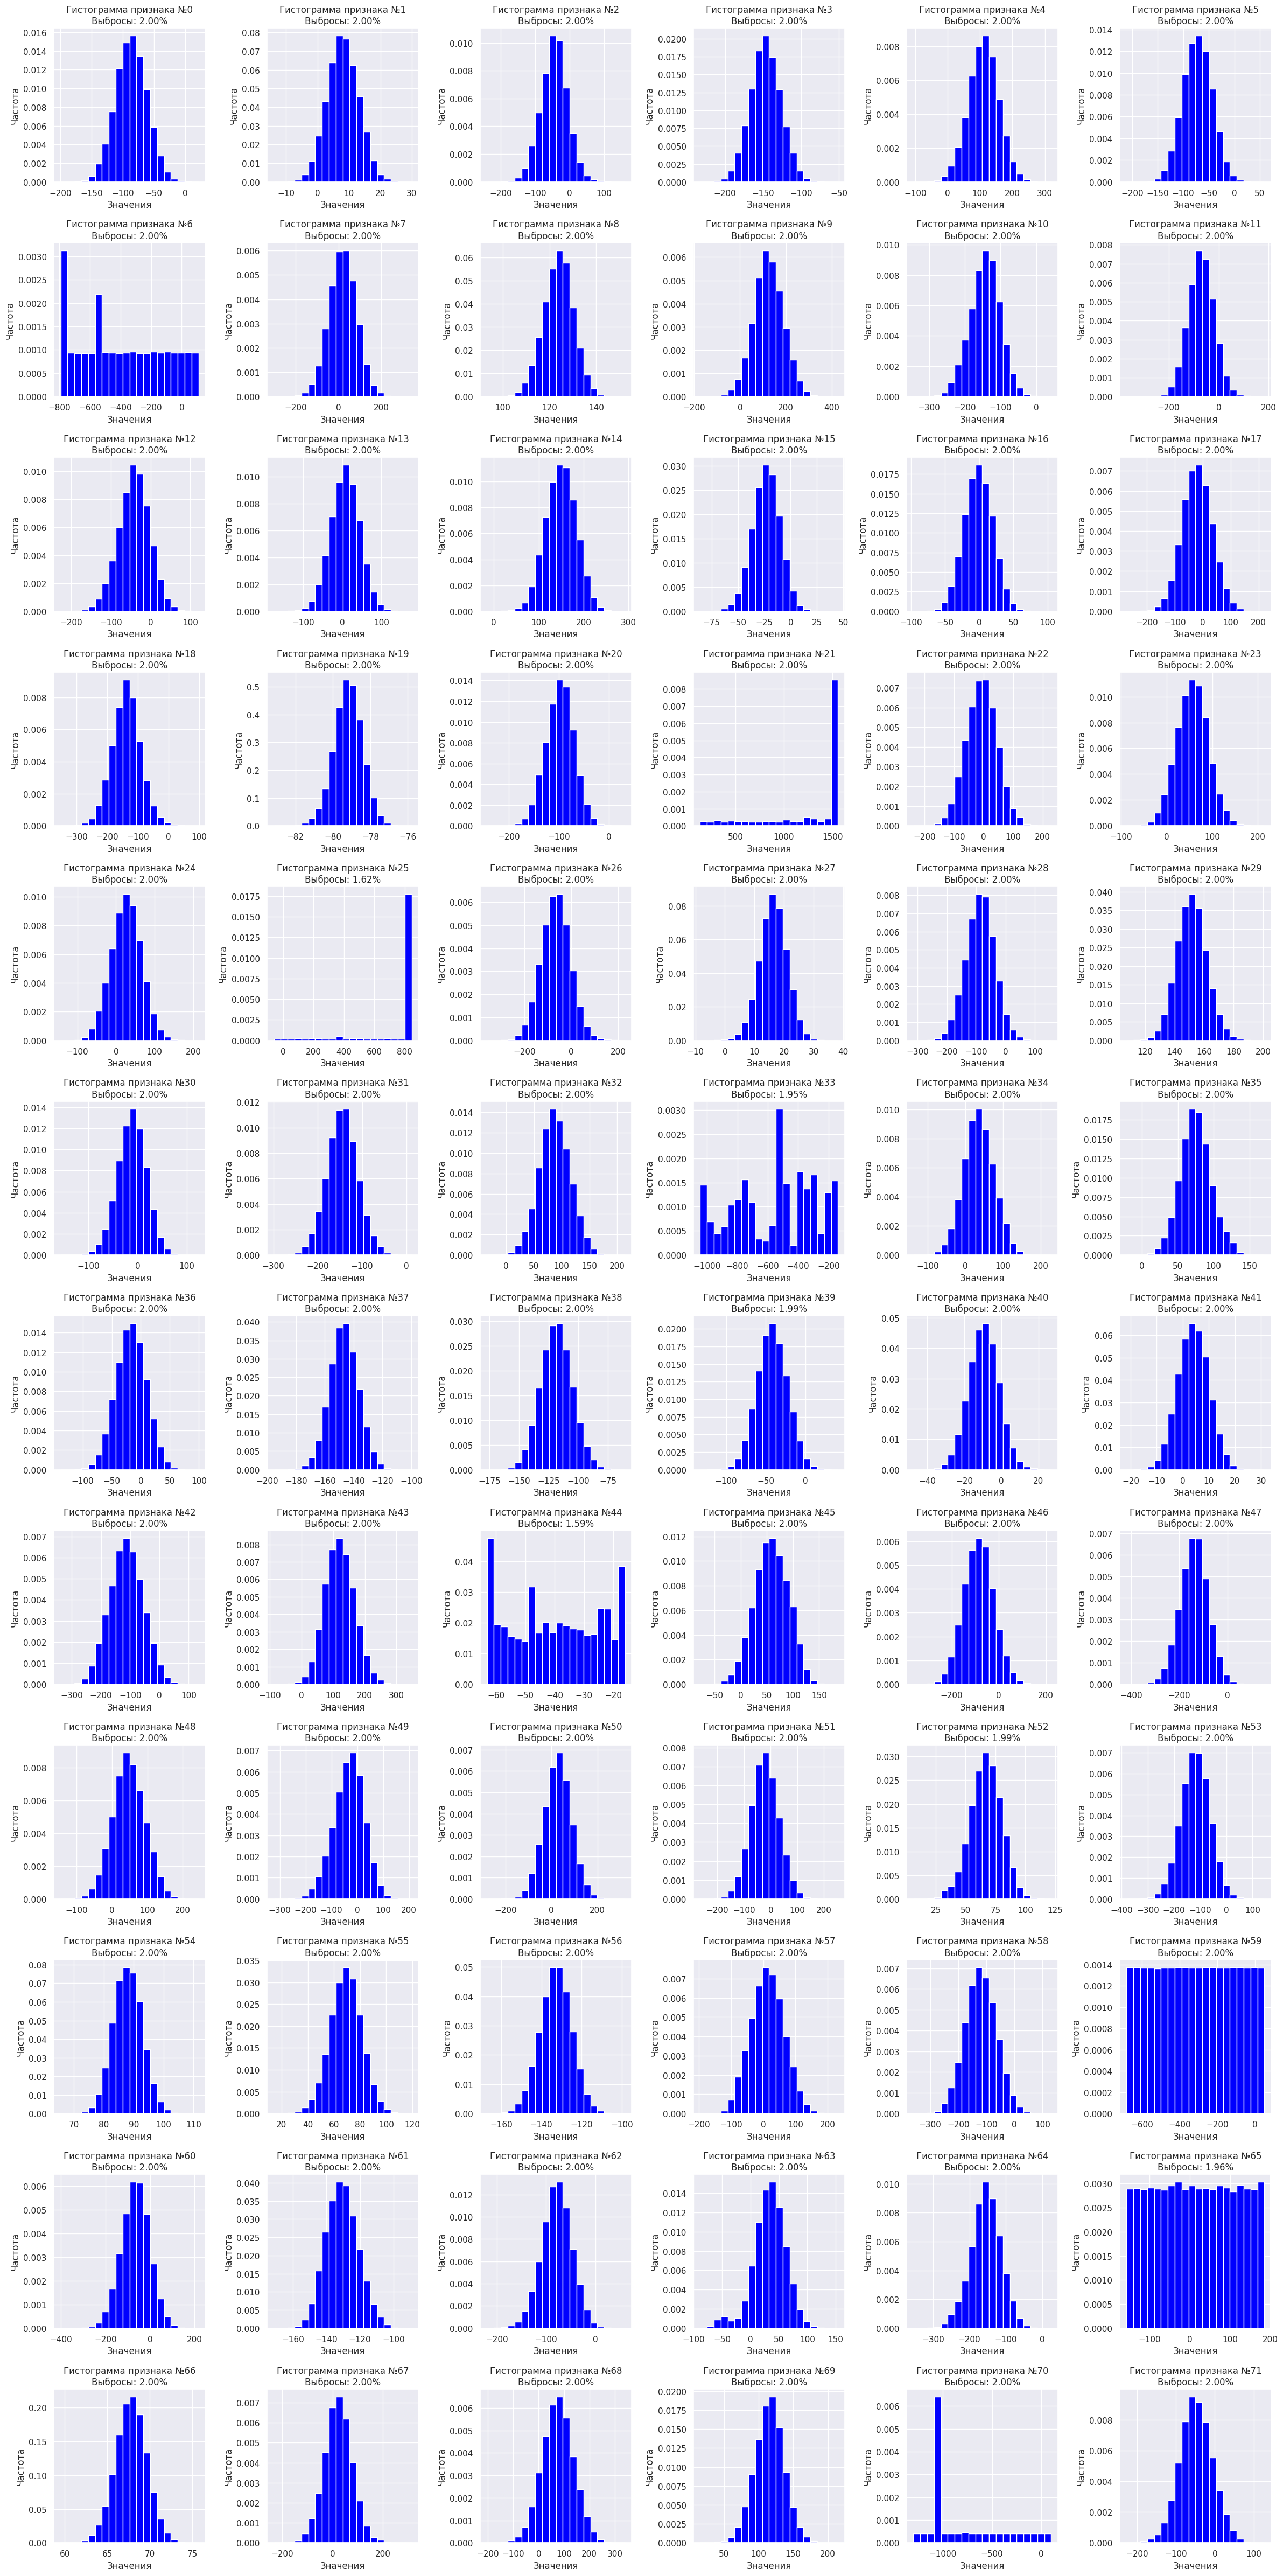

CPU times: user 48.5 s, sys: 318 ms, total: 48.8 s
Wall time: 49 s


In [ ]:
%%time
show_graph_matrix_(base_df_large, color='blue', x=6, y=12)

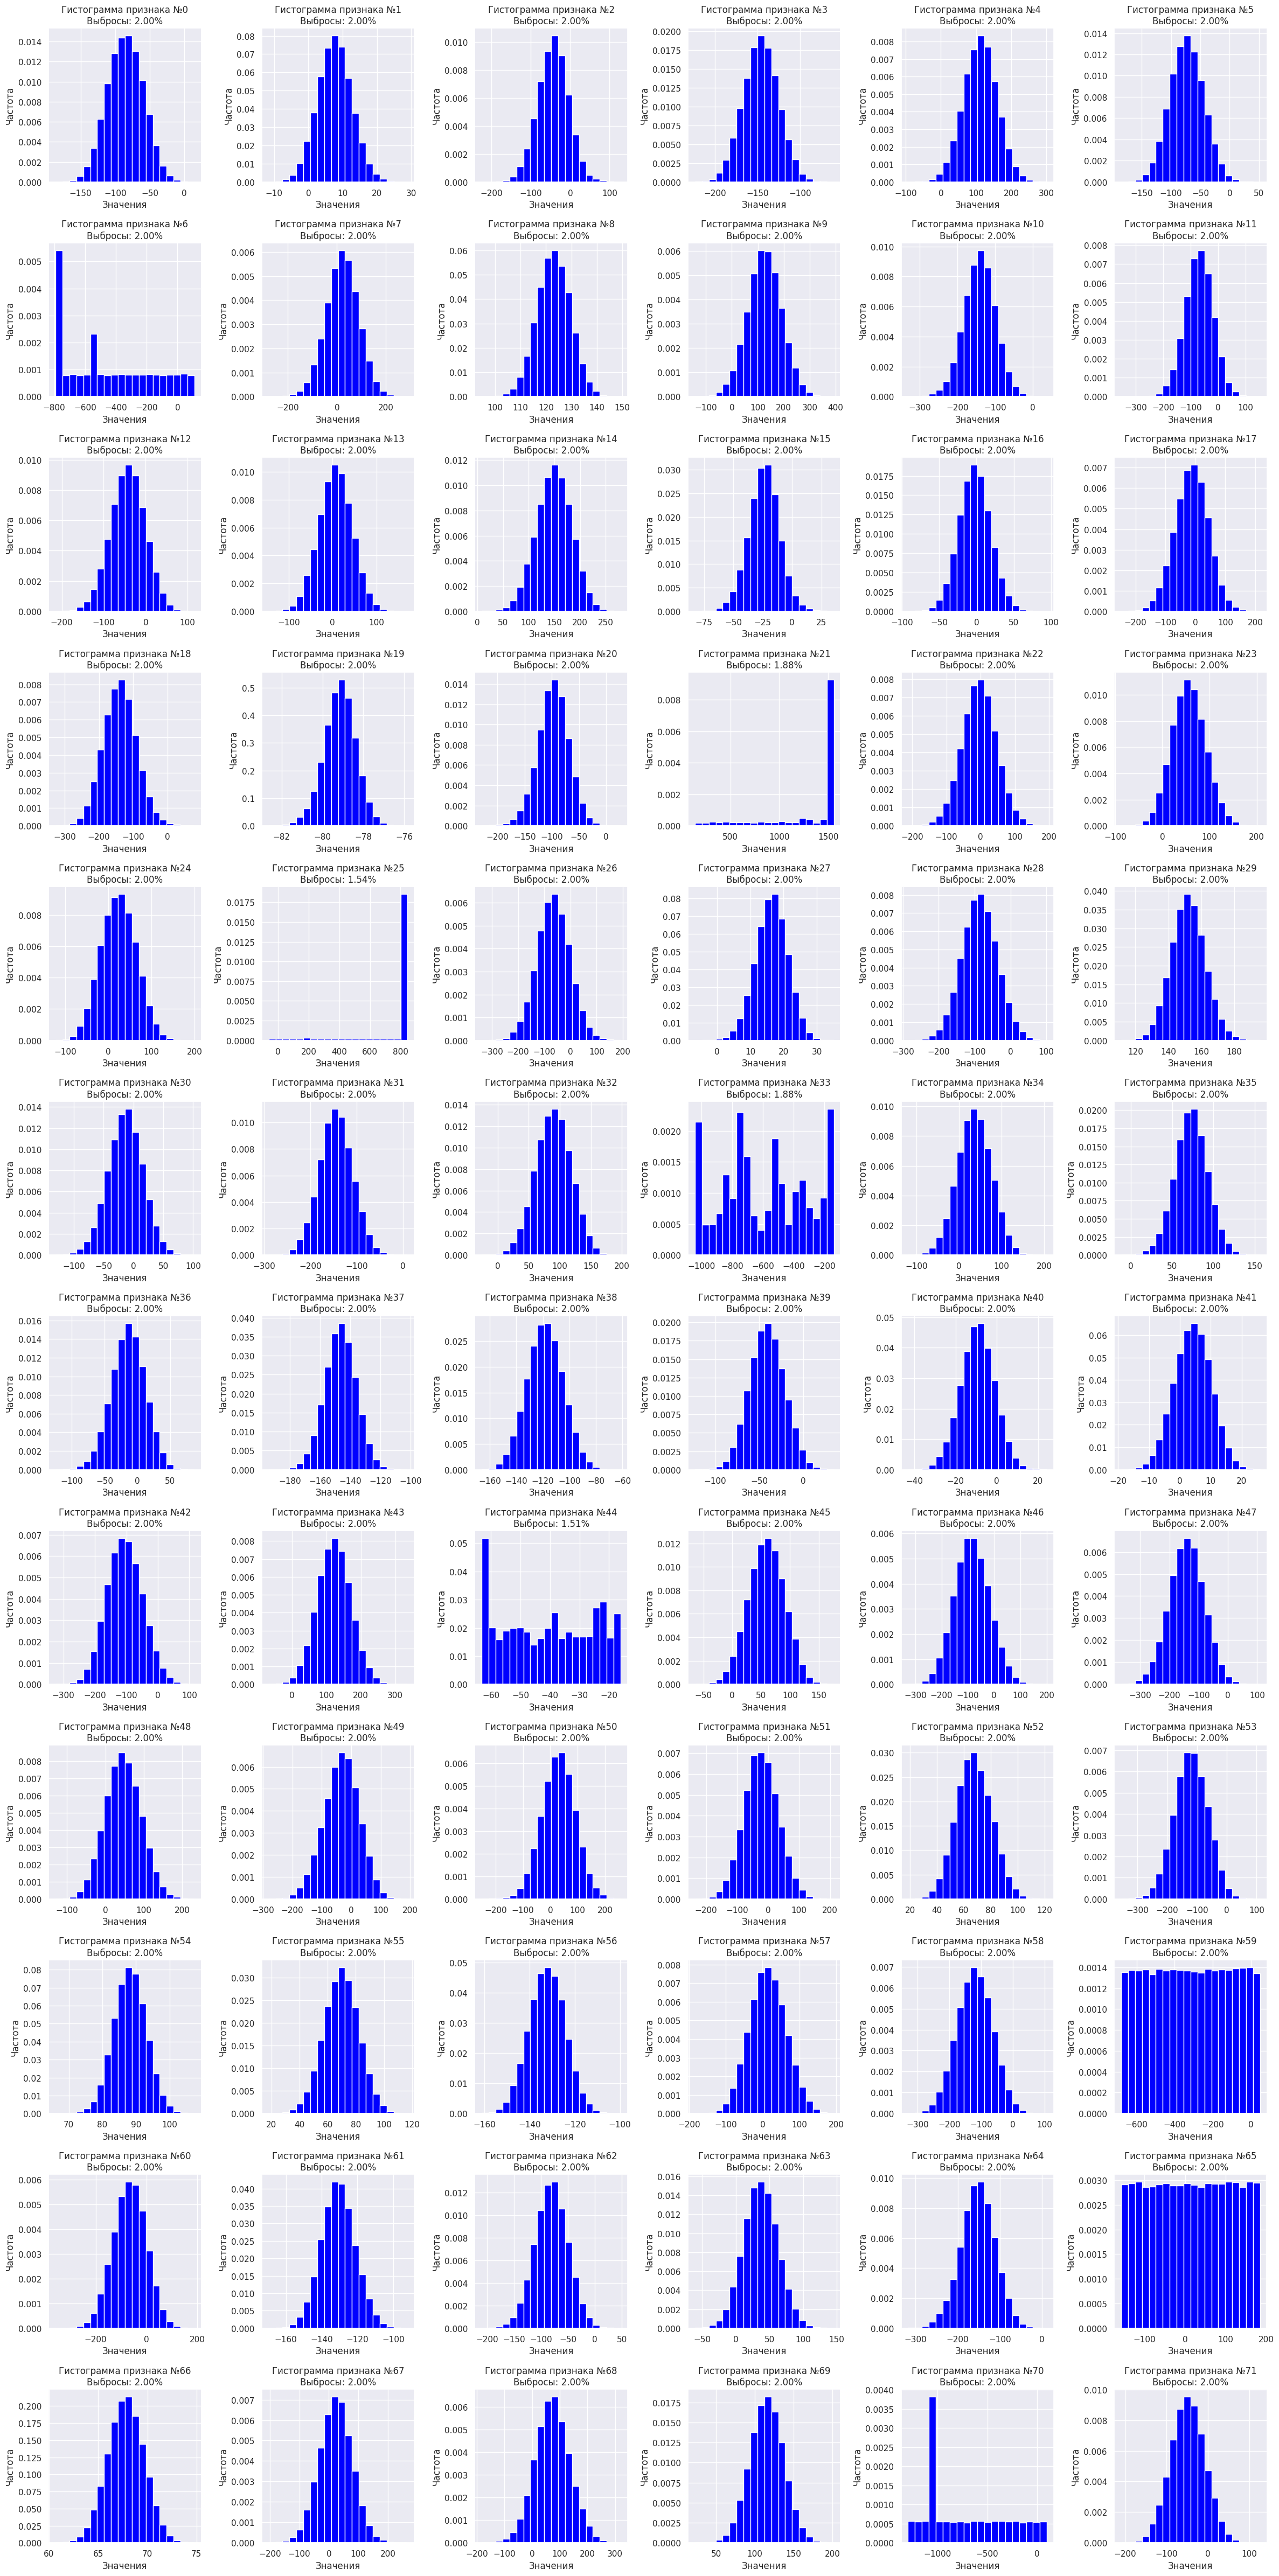

CPU times: user 31.9 s, sys: 238 ms, total: 32.1 s
Wall time: 32.5 s


In [ ]:
%%time
show_graph_matrix_(train_df_large, color='blue', x=6, y=12)

In [ ]:
%%time
show_graph_matrix_(valid_df_large, color='blue', x=6, y=12)

**ВЫВОД:**

В первом разделе проекта были выполнены следующие шаги:

Общий вывод по загрузке и первичному обзору данных:

Данные успешно загружены и проанализированы. Все четыре датасета (base_df_large, train_df_large, valid_df_large, valid_targets_large) содержат значительное количество строк и столбцов, что указывает на объемный и богатый информацией набор данных.
Структура данных: Датасеты base_df_large и valid_df_large содержат 72 столбца, датасет train_df_large — 73 столбца (дополнительный столбец Target), и датасет valid_targets_large — 2 столбца. Все датасеты содержат уникальные идентификаторы в столбце id.
Краткий анализ гистограмм:

**Распределение признаков:**

Большинство количественных признаков в датасетах имеют нормальное или близкое к нормальному распределение.
Некоторые признаки имеют мультимодальное распределение, что может указывать на наличие нескольких групп или кластеров в данных.
Выбросы:

Выбросы были определены на основе 1% и 99% квантилей. Для каждого признака отображались гистограммы с указанием процента выбросов.
Процент выбросов для большинства признаков оказался низким (менее 2-3%), что свидетельствует о высокой однородности данных. Однако, для некоторых признаков процент выбросов был выше, что требует дополнительного анализа и, возможно, очистки данных.
Аномалии:

Были выявлены признаки с подозрительными распределениями. Эти признаки требуют более детального анализа, чтобы определить причину аномалий и принять решение о дальнейшем их использовании.
Визуализация данных:

Визуализация гистограмм предоставила ценную информацию о распределении признаков и наличии выбросов. Это поможет в дальнейшей предобработке данных, включая нормализацию и устранение выбросов. Такие признаки как: 6, 21, 25, 33, 44, 59, 65 и 70 имеют не нормальное распределение.

**Корреляция**

Проверим наличие линейной зависимости

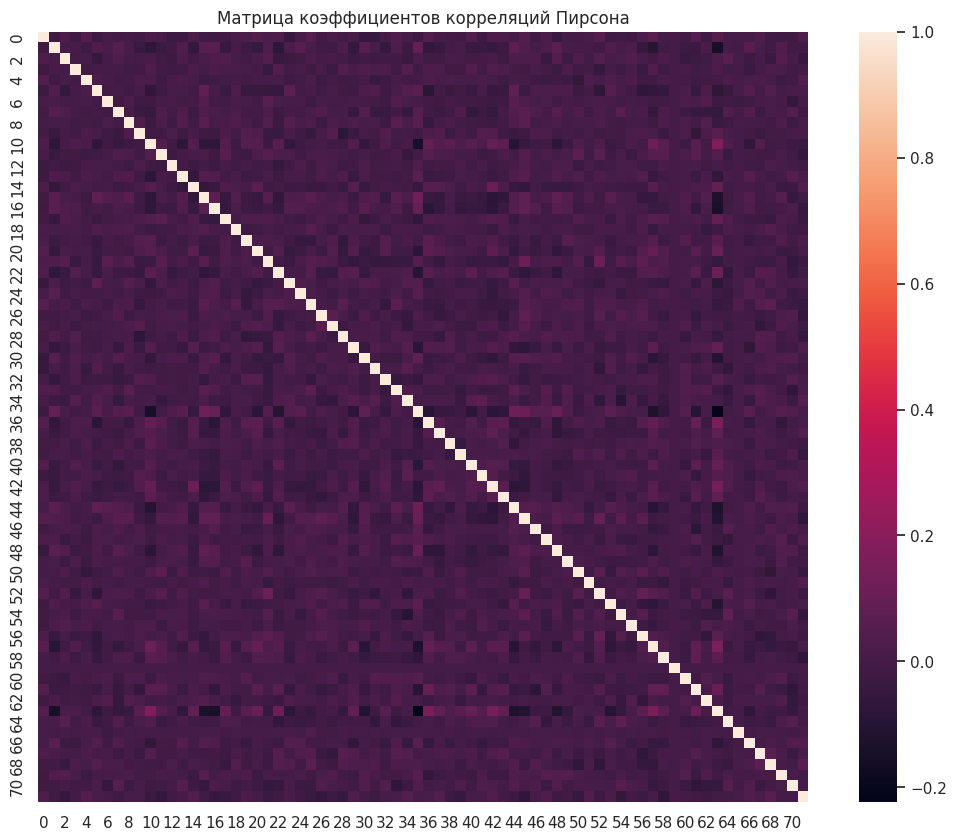

In [ ]:
# корреляций Пирсона
sns.set(rc = {'figure.figsize':(13, 10)})
sns.heatmap(base_df_large.corr(), square=True)
plt.title('Матрица коэффициентов корреляций Пирсона')
plt.show()

**Промежуточный вывод:**

Тип данных - соответствует. Все значения - это числа с плавающий запятов типа float32, а id товаров - данные типа object или string.

Пропуски - отсутствуют.

Существует "дисбаланс" между значениями. А именно, некоторые значения встречаются особо часто в сравнении со всеми остальными.
Дубликаты - отсутствуют, за исключением valid_targets_large. Это может говорить, что одному и тому же "старому" товару, может соответствовать несколько "новых".

Явная зависимость между признаками - отсутствует. Всех их можно считать уникальными характеристиками товара.

Значения признаков сильно отличаются друг от друга. Они могут быть как положительными, так и отрицательными. Могут занимать широкий или узкий числовой диапазон. Для того чтобы каждый признак изначально имел одинаковую значимость необходимо произвести Масштабирование.

Далее приступим к подготовке данных для модели. Для этого изучим уменьшенную выборку, далее все манипуляции будут проводится с ее данными

In [ ]:
%%time
base_df.head()

In [ ]:
base_df.duplicated().sum()

In [ ]:
base_df.shape

(291813, 72)

In [ ]:
%%time
train_df.head()

CPU times: user 227 µs, sys: 4 µs, total: 231 µs
Wall time: 238 µs


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
109249-query,-24.021454,3.122524,-80.947525,-112.329994,191.090180,-66.903130,-759.626065,-75.284454,120.55149,131.131700,-149.211060,-102.31221,21.387623,11.277594,143.22140,-22.011570,-3.618249,-16.005480,-133.38228,-78.89356,-65.690530,407.773575,-11.660624,67.008150,24.975033,813.770071,40.051064,17.933155,-75.435745,149.81720,-23.413877,-178.095570,133.786470,-906.571061,113.355560,83.942260,-16.592659,-146.52074,-120.237860,-27.341612,-8.845615,1.027612,-175.647720,167.735820,-32.931559,47.860960,-196.247500,-118.81005,-4.762772,-114.877680,37.397278,-55.616966,56.627056,-108.43317,87.372560,76.513430,-136.27057,3.652915,-164.574510,-635.284275,-75.647255,-116.679340,-41.234684,-24.601670,-167.760770,133.678516,68.184600,26.317545,11.938202,148.549320,-778.563381,-46.877750,66971-base
34137-query,-82.033580,8.115866,-8.793022,-182.972100,56.645336,-52.597610,-55.720337,130.059250,129.38335,76.202880,-137.799420,33.30165,-2.868191,-34.318770,189.06479,-19.337550,-14.208210,-71.110245,-157.74814,-78.70069,-91.741875,1054.205600,-41.845630,102.128620,72.559050,813.770071,-37.957787,17.598982,-159.975400,140.02528,-8.819328,-147.055180,113.819870,-529.295053,70.674940,55.976795,8.817799,-134.14812,-73.679794,-57.566544,-4.338496,-3.270682,-144.499200,144.650200,-37.903276,58.913525,-105.362840,-125.66783,19.367283,-29.087658,-35.021350,26.627962,55.718437,-110.52611,83.513374,75.926130,-135.68242,-7.429803,-180.645020,11.470171,16.464691,-121.807236,-90.814450,54.448433,-120.894806,-12.292085,66.608116,-27.997612,10.091335,95.809265,-1022.691531,-88.564705,1433819-base
136121-query,-75.719640,-0.223386,-86.186130,-162.064060,114.320114,-53.394600,-117.261013,-24.857851,124.80780,112.190155,-200.925960,-38.86518,-80.611270,14.343805,156.62129,-22.498169,-26.359468,-109.034870,-106.92659,-79.74731,-69.876830,1507.231274,-20.058287,34.334927,23.592144,813.770071,-49.503860,22.166200,-85.740160,134.83647,-69.569850,-139.887240,67.377045,-341.781842,54.161224,81.891660,36.421352,-159.99583,-131.916080,-20.495195,-13.976569,-2.355247,-216.228650,238.836490,-56.611536,43.366640,7.191841,-159.48369,-19.338009,-51.409897,36.819540,32.536880,80.681020,-232.40741,84.053690,59.086180,-139.85950,78.409440,-115.940575,2.426572,7.594826,-126.520134,-73.148960,-5.609123,-93.029880,-80.997871,63.733383,11.378683,62.932007,130.975390,-1074.464888,-74.861176,290133-base
105191-query,-56.580620,5.093593,-46.943110,-149.039120,112.436430,-76.820510,-324.995645,-32.833107,119.47865,120.074790,-61.347084,-28.67060,-102.790180,-36.194320,157.18976,-33.318240,7.448413,-47.230713,-178.04608,-78.78652,-106.235440,1507.231274,-63.414307,38.099255,-89.795350,813.770071,-107.432390,10.052701,-71.917380,147.74005,-18.750763,-143.795620,67.207310,-366.139446,112.187700,78.144810,-41.085410,-132.75719,-89.445030,-19.267069,-14.866466,7.775788,-104.302110,74.622894,-59.875136,76.406470,-77.797020,-92.01658,19.337300,-37.922787,37.271270,111.639570,94.912950,-179.72540,86.601480,62.698364,-122.16293,29.873940,-53.508120,-0.938894,-36.919907,-144.555000,-96.798590,21.624313,-158.880370,179.597294,69.891360,-33.804955,233.914610,122.868546,-1074.464888,-93.775375,1270048-base
63983-query,-52.725650,9.027046,-92.829650,-113.111010,134.124970,-42.423073,-759.626065,8.261169,119.49023,172.365360,-186.641390,-84.94380,-92.339966,-30.229528,167.86163,-22.635653,0.014536,-9.796367,-213.10180,-78.59006,-98.728300,1250.423749,-43.892487,86.288450,-1.549826,813.770071,-110.356980,24.055641,-96.578270,156.58230,45.124240,-123.888504,118.035110,-607.946912,52.311410,76.747800,-14.161914,-143.53851,-124.886215,-64.783330,-17.706848,15.446568,-53.554455,174.381620,-23.140892,76.419330,-73.

In [ ]:
train_df.shape

(9999, 73)

In [ ]:
%%time
valid_df.shape

CPU times: user 28 µs, sys: 1e+03 ns, total: 29 µs
Wall time: 32.2 µs


(10000, 72)

In [ ]:
%%time
valid_df.head()

CPU times: user 236 µs, sys: 0 ns, total: 236 µs
Wall time: 243 µs


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
196680-query,-59.383420,8.563436,-28.203072,-134.22534,82.73661,-150.572170,-129.178969,23.670555,125.66636,108.809586,-129.48387,-178.983060,-109.600174,-8.799808,172.95998,-20.794373,-30.065893,-14.889741,-213.47429,-81.442860,-92.558720,1507.231274,96.508420,87.975250,55.862797,813.770071,1.647972,16.160482,-77.401474,166.08685,-7.085945,-114.40581,116.564270,-481.586956,40.185913,73.085365,-37.582203,-140.10822,-113.26041,-64.863230,-16.001427,7.223721,-5.791832,154.656310,-34.690983,52.748238,-34.976818,-160.459520,-28.526081,11.436787,107.386640,33.117570,56.67899,-43.842407,95.18327,51.950043,-123.31064,-10.645209,-52.291348,-525.623407,53.718872,-129.388460,-103.481630,79.564530,-120.31357,54.218155,68.50073,32.681908,84.19686,136.412960,-1074.464888,-21.233612
134615-query,-103.912150,9.742726,-15.209915,-116.37310,137.69880,-85.530075,-776.123158,44.481530,114.67121,95.231290,-166.03618,-66.359830,-36.001366,3.264235,73.06930,-29.384926,22.245693,62.498410,-114.18031,-80.017426,-56.034016,914.812090,-23.072426,64.591540,47.074090,813.770071,1.761437,24.459257,-177.638370,157.88023,-15.648800,-174.11716,37.697598,-701.605866,18.383450,81.502020,22.231460,-129.41878,-117.69812,-53.364460,-4.394635,11.108950,-109.880050,102.263280,-47.268603,52.336370,31.617912,13.088348,0.388435,-55.594444,-37.935482,-46.970780,50.48210,-132.518330,88.67881,81.240204,-130.75761,4.710941,-114.013050,-433.616738,-119.455990,-129.188340,-51.193770,49.299644,-101.89454,105.560548,67.80104,13.633057,108.05138,111.864456,-841.022331,-76.567980
82675-query,-117.923280,-3.504554,-64.299390,-155.18713,156.82137,-34.082264,-537.423653,54.078613,121.97396,59.321335,-90.08289,4.986931,-52.514560,52.529945,140.47353,-4.860558,-18.063830,-36.537400,-137.92374,-79.661070,-70.733120,1507.231274,-7.057582,26.213560,-2.779066,813.770071,-69.704410,16.080505,-90.432610,137.94106,24.971474,-138.86641,92.287190,-735.671365,68.335190,78.208220,14.043610,-147.51697,-113.89963,-18.748684,-8.779379,-8.737224,-177.382870,156.102450,-35.756027,65.317690,-262.907840,-96.018070,55.713432,22.165249,151.100540,-24.815138,70.92110,-121.119310,91.86982,87.153366,-138.07550,-3.309690,14.035965,-107.596636,-152.853940,-118.997840,-115.176155,48.636130,-132.17967,-0.988696,68.11125,107.065216,134.61765,134.080000,27.773269,-32.401714
162076-query,-90.880554,4.888542,-39.647797,-131.75010,62.36212,-105.593270,-347.132493,-83.351750,133.91331,201.146090,-193.19345,-31.961876,-11.191006,-28.481222,157.13997,-39.513940,-20.431585,30.671173,-131.63226,-79.841600,-74.222690,1507.231274,-75.135840,34.678430,-14.997078,401.379624,-29.014805,17.788988,-87.424790,160.81638,-13.624538,-137.01877,89.403885,-388.662473,-0.446587,73.493530,3.995680,-144.55515,-125.87352,-35.733467,-9.979044,2.092319,-114.457405,158.609240,-58.275016,96.416830,-166.106690,-36.610770,95.944460,-43.662690,33.869110,30.895940,65.87759,-106.503220,94.52601,72.289566,-152.20987,29.090012,-188.342150,-327.117943,43.212470,-139.852200,-112.293790,54.884007,-177.56935,-116.374997,67.88766,136.893980,124.89447,117.707750,-566.343980,-90.905556
23069-query,-66.946740,10.562773,-73.781830,-149.39787,2.93866,-51.288853,-587.189361,-2.764402,126.56105,131.900620,-131.93640,-35.794685,-155.979580,-2.110109,137.72418,-11.544052,-12.957520,2.028175,-129.12962,-79.461266,-72.883120,1507.231274,-47.112600,7.837235,-8.623394,813.770071,-60.251694,11.591301,-82.794800,134.84439,4.764982,-114.47928,83.150400,-156.249890,41.852833,42.160450,-58.565960,-146.39613,-90.59503,-53.295376,-12.213371,-8.682546,-142.693270,71.629135,-57.668621,55.122387,10.182793,-100.190810,-45.052837,-46.877544,10.418076,106.135445,75.15257,-110.051500,83.05377,97.87521

In [ ]:
valid_targets.head()

,Expected
Id,
196680-query,1087368-base
134615-query,849674-base
82675-query,4183486-base
162076-query,2879258-base
23069-query,615229-base


In [ ]:
valid_targets.shape

(10000, 1)

Предварительный анализ уменьшенной выборки показал, что в тренировочной выборке присутствуют дубликаты. Однако удалять их не требуется, это объясняется тем, что один и тот же товар может подходить для нескольких id. Пропусков по аналогии с большой выборкой нет. Cчитаю необходимым удалить столбцы с признаками, которые распределены не нормально, т.к модели FAISS очень требовательны к нормальному распределению признаков, и признаками с корреляцией равной 0. всего необходимо удалить 7 столбцов. После удаления столбцов приступим к масштабированию признаков. Для этого воспользуемся универсальным StandardScaler(), т.к опять же оставленные признаки имеют нормальное распределение.

In [ ]:
target_valid = valid_targets["Expected"]

In [ ]:
train_df.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60',
       '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71',
       'Target'],
      dtype='object')

In [ ]:
targets = train_df["Target"]
train_df.drop("Target", axis=1, inplace=True)

In [ ]:
train_df.drop(['21', '25','33', '44', '59', '65', '70'], axis=1, inplace=True)

In [ ]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,22,23,24,26,27,28,29,30,31,32,34,35,36,37,38,39,40,41,42,43,45,46,47,48,49,50,51,52,53,54,55,56,57,58,60,61,62,63,64,66,67,68,69,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
109249-query,-24.021454,3.122524,-80.947525,-112.329994,191.090180,-66.903130,-759.626065,-75.284454,120.55149,131.131700,-149.211060,-102.31221,21.387623,11.277594,143.22140,-22.011570,-3.618249,-16.005480,-133.38228,-78.89356,-65.690530,-11.660624,67.008150,24.975033,40.051064,17.933155,-75.435745,149.81720,-23.413877,-178.095570,133.786470,113.355560,83.942260,-16.592659,-146.52074,-120.237860,-27.341612,-8.845615,1.027612,-175.647720,167.735820,47.860960,-196.247500,-118.81005,-4.762772,-114.877680,37.397278,-55.616966,56.627056,-108.43317,87.372560,76.513430,-136.27057,3.652915,-164.574510,-75.647255,-116.679340,-41.234684,-24.601670,-167.760770,68.184600,26.317545,11.938202,148.549320,-46.877750
34137-query,-82.033580,8.115866,-8.793022,-182.972100,56.645336,-52.597610,-55.720337,130.059250,129.38335,76.202880,-137.799420,33.30165,-2.868191,-34.318770,189.06479,-19.337550,-14.208210,-71.110245,-157.74814,-78.70069,-91.741875,-41.845630,102.128620,72.559050,-37.957787,17.598982,-159.975400,140.02528,-8.819328,-147.055180,113.819870,70.674940,55.976795,8.817799,-134.14812,-73.679794,-57.566544,-4.338496,-3.270682,-144.499200,144.650200,58.913525,-105.362840,-125.66783,19.367283,-29.087658,-35.021350,26.627962,55.718437,-110.52611,83.513374,75.926130,-135.68242,-7.429803,-180.645020,16.464691,-121.807236,-90.814450,54.448433,-120.894806,66.608116,-27.997612,10.091335,95.809265,-88.564705
136121-query,-75.719640,-0.223386,-86.186130,-162.064060,114.320114,-53.394600,-117.261013,-24.857851,124.80780,112.190155,-200.925960,-38.86518,-80.611270,14.343805,156.62129,-22.498169,-26.359468,-109.034870,-106.92659,-79.74731,-69.876830,-20.058287,34.334927,23.592144,-49.503860,22.166200,-85.740160,134.83647,-69.569850,-139.887240,67.377045,54.161224,81.891660,36.421352,-159.99583,-131.916080,-20.495195,-13.976569,-2.355247,-216.228650,238.836490,43.366640,7.191841,-159.48369,-19.338009,-51.409897,36.819540,32.536880,80.681020,-232.40741,84.053690,59.086180,-139.85950,78.409440,-115.940575,7.594826,-126.520134,-73.148960,-5.609123,-93.029880,63.733383,11.378683,62.932007,130.975390,-74.861176
105191-query,-56.580620,5.093593,-46.943110,-149.039120,112.436430,-76.820510,-324.995645,-32.833107,119.47865,120.074790,-61.347084,-28.67060,-102.790180,-36.194320,157.18976,-33.318240,7.448413,-47.230713,-178.04608,-78.78652,-106.235440,-63.414307,38.099255,-89.795350,-107.432390,10.052701,-71.917380,147.74005,-18.750763,-143.795620,67.207310,112.187700,78.144810,-41.085410,-132.75719,-89.445030,-19.267069,-14.866466,7.775788,-104.302110,74.622894,76.406470,-77.797020,-92.01658,19.337300,-37.922787,37.271270,111.639570,94.912950,-179.72540,86.601480,62.698364,-122.16293,29.873940,-53.508120,-36.919907,-144.555000,-96.798590,21.624313,-158.880370,69.891360,-33.804955,233.914610,122.868546,-93.775375
63983-query,-52.725650,9.027046,-92.829650,-113.111010,134.124970,-42.423073,-759.626065,8.261169,119.49023,172.365360,-186.641390,-84.94380,-92.339966,-30.229528,167.86163,-22.635653,0.014536,-9.796367,-213.10180,-78.59006,-98.728300,-43.892487,86.288450,-1.549826,-110.356980,24.055641,-96.578270,156.58230,45.124240,-123.888504,118.035110,52.311410,76.747800,-14.161914,-143.53851,-124.886215,-64.783330,-17.706848,15.446568,-53.554455,174.381620,76.419330,-73.357605,-128.12526,-34.571490,-2.756741,44.027752,-13.445387,62.028725,-99.98626,79.376854,49.966180,-131.30576,-71.270520,-262.396970,-43.734640,-127.425110,-81.566216,13.807772,-208.650040,66.522420,41.362930,162.723050,111.261310,-33.831450


In [ ]:

base_df.drop(['21', '25','33', '44', '59', '65', '70'], axis=1, inplace=True)

In [ ]:
valid_df.drop(['21', '25','33', '44', '59', '65', '70'], axis=1, inplace=True)

In [ ]:
%%time
scaler = StandardScaler()
scaler.fit(base_df)
base_transform  = scaler.transform(base_df)
train_transform = scaler.transform(train_df)
valid_transform = scaler.transform(valid_df)

# пример
print('Пример масштабированного вектора из "base":\n',  base_transform[0],  '\n')
print('Пример масштабированного вектора из "train":\n', train_transform[0], '\n')
print('Пример масштабированного вектора из "valid":\n', valid_transform[0], '\n')

Пример масштабированного вектора из "base":
 [ 1.69865009  1.47213081  1.61182892  0.72037061  0.98820354  2.40533869
  0.19405592 -1.2122185   0.74321748 -1.23256934  0.39203062  1.45403938
 -1.50634585  1.02030355  0.85005453  0.83369851  1.89233216  2.35283487
 -0.10882442 -1.28514886 -0.42948132 -1.207608    0.27850257  1.49445885
 -0.24433216 -0.02893245 -0.2475753   0.7724235   1.3521894  -1.86076299
 -0.90750419  1.9612541   0.71324825 -0.14734247 -1.81869258 -1.12672627
  0.03383399 -0.09101114  0.72384804 -0.32740598 -0.9644167  -0.56799446
 -0.96410022 -0.08428927  0.04082757  1.64847939 -0.96232959  0.81653694
  0.84562324 -0.19976312  0.89963501 -0.44509285 -1.05917789  2.54156928
  0.48146964 -0.40182785  0.17473887  0.23447702 -0.08765442  1.56559282
 -0.44936417  1.49591856 -1.94325146  1.9028522   0.54239661] 

Пример масштабированного вектора из "train":
 [ 2.49823537 -1.00122777 -0.94261856  1.72736432  1.72230835  0.17637244
 -1.34588948 -1.48803683 -0.4919393   0.10

Исследование опции FAISS и разработка ранжирующей модели

FAISS (Facebook AI Similarity Search) - это библиотека для эффективного поиска похожих векторов в больших наборах данных. Она предоставляет оптимизированные алгоритмы для поиска ближайших соседей, кластеризации и квантизации векторов.

Основные опции FAISS включают в себя:

1. Индексация: FAISS предоставляет различные типы индексов, такие как IndexFlat, IndexIVFFlat, IndexIVFPQ и другие, для эффективного хранения и быстрого поиска векторов.

2. Параметры поиска: FAISS позволяет настраивать параметры поиска, такие как количество ближайших соседей, расстояние (L2, IP, Cosine) и другие.

3. Многопоточность: FAISS поддерживает многопоточность для ускорения процесса поиска похожих векторов.

Что касается разработки ранжирующей модели, то это задача построения системы, которая упорядочивает элементы по их значимости или релевантности для конечного пользователя. Для этого обычно используют машинное обучение, где модель обучается на основе исторических данных о предпочтениях пользователей или других признаках.

In [ ]:
# Определение размерности векторов
vector_dimension = base_transform.shape[1]  # Размерность второй оси (второе измерение)
print("Размерность векторов:", vector_dimension)

Размерность векторов: 65


In [ ]:
base_index = {k: v for k, v in enumerate(base_df.index.to_list())}

print('Пример содержания словаря:\n', list(base_index.items())[0:3])

Пример содержания словаря:
 [(0, '4207931-base'), (1, '2710972-base'), (2, '1371460-base')]


Для перебора гиперпараметров будем использовать OPTUNA

**Гиперпараметры** — это параметры, которые не учатся в процессе обучения модели. Они задаются заранее. От выбора гиперпараметров напрямую зависит качество и эффективность модели, а их оптимизация может улучшить результаты предсказаний. Optuna решает проблему оптимизации гиперпараметров, предоставляя легковесный фреймворк для автоматизации поиска оптимальных гиперпараметров. Она использует алгоритмы, такие как TPE, CMA-ES, и даже поддерживает пользовательские алгоритмы.

Напишем функцию. Передадим три гиперпараметра 'n_cells', 'n_probes', 'nbits'. candidate_number по условию равен 5. Получим лучшие гиперпараметры и получим предсказания и метрику на тестовой выборке.

1. n_cells (число ячеек в индексе IVF):
   • Этот параметр определяет количество подразделений, или ячеек, в индексе инвертированного списка (IVF), который используется в FAISS для ускорения поиска ближайших соседей.
   • Увеличение n_cells может улучшить точность поиска на маленьких наборах данных, но может повлечь за собой увеличение использования памяти и времени поиска.

2. n_probes (число проверок при поиске в индексе):
   • Этот параметр указывает на количество проверок, которые производятся при поиске ближайших соседей в каждой ячейке индекса.
   • Увеличение n_probes может улучшить точность поиска, но может также увеличить время поиска и использование ресурсов.

3. nbits (число битов для квантования при построении индекса):
   • Этот параметр используется в методах квантования для снижения размерности векторов путем кодирования их значения в виде битов.
   • Увеличение nbits приведет к более точному представлению векторов, но также может увеличить потребление памяти и скорость вычислений.

Эти параметры следует настраивать и подбирать в зависимости от конкретного набора данных и задачи для достижения оптимальной производительности и качества поиска.

In [ ]:
%%time
def objective(trial):
    n_cells = trial.suggest_int('n_cells', 1, 300)
    n_probes = trial.suggest_int('n_probes', 1, 32)
    candidate_number = 5  # Проверяем точность только на топ-5

    quantizer = faiss.IndexFlatL2(base_transform.shape[1])
    idx_l2 = faiss.IndexIVFFlat(quantizer, base_transform.shape[1], n_cells)
    idx_l2.nprobe = n_probes
    idx_l2.train(np.ascontiguousarray(base_transform).astype('float32'))
    idx_l2.add(np.ascontiguousarray(base_transform).astype('float32'))
    r, idx = idx_l2.search(np.ascontiguousarray(train_transform).astype('float32'), candidate_number)

    acc = 0
    for target, el in zip(targets.values.tolist(), idx.tolist()):
        top_predictions = [base_index[r] for r in el]
        acc += int(target in top_predictions)

    accuracy = acc / len(idx)*100

    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

best_params = study.best_params
best_accuracy = study.best_value
print("Best Parameters:", best_params)
print("Best Accuracy@5:", best_accuracy)

[I 2024-08-30 15:35:38,783] A new study created in memory with name: no-name-11542645-178a-49d2-9ae3-aab6656148c7
[I 2024-08-30 15:35:55,975] Trial 0 finished with value: 77.84778477847784 and parameters: {'n_cells': 234, 'n_probes': 13}. Best is trial 0 with value: 77.84778477847784.
[I 2024-08-30 15:36:42,615] Trial 1 finished with value: 78.5078507850785 and parameters: {'n_cells': 251, 'n_probes': 32}. Best is trial 1 with value: 78.5078507850785.
[I 2024-08-30 15:36:59,180] Trial 2 finished with value: 75.68756875687569 and parameters: {'n_cells': 52, 'n_probes': 3}. Best is trial 1 with value: 78.5078507850785.
[I 2024-08-30 15:37:58,502] Trial 3 finished with value: 78.5978597859786 and parameters: {'n_cells': 167, 'n_probes': 27}. Best is trial 3 with value: 78.5978597859786.
[I 2024-08-30 15:42:21,942] Trial 4 finished with value: 79.43794379437944 and parameters: {'n_cells': 23, 'n_probes': 22}. Best is trial 4 with value: 79.43794379437944.
[I 2024-08-30 15:42:25,385] Trial 

Best Parameters: {'n_cells': 23, 'n_probes': 22}
Best Accuracy@5: 79.43794379437944
CPU times: user 45min 7s, sys: 4.24 s, total: 45min 11s
Wall time: 34min 44s


In [111]:
%%time
def train_model_with_best_params(best_params, base_transform, targets):
    n_cells = best_params['n_cells']
    n_probes = best_params['n_probes']

    quantizer = faiss.IndexFlatL2(base_transform.shape[1])
    idx_l2 = faiss.IndexIVFFlat(quantizer, base_transform.shape[1], n_cells)
    idx_l2.nprobe = n_probes
    idx_l2.train(np.ascontiguousarray(base_transform).astype('float32'))
    idx_l2.add(np.ascontiguousarray(base_transform).astype('float32'))

    return idx_l2

def evaluate_model(model, valid_transform, target_valid):
    candidate_number = 5
    r, idx = model.search(np.ascontiguousarray(valid_transform).astype('float32'), candidate_number)

    acc = 0
    for target, el in zip(target_valid.values.tolist(), idx.tolist()):
        top_predictions = [base_index[r] for r in el]
        acc += int(target in top_predictions)

    accuracy = acc / len(idx)*100

    return accuracy

model = train_model_with_best_params(best_params, base_transform, targets)
accuracy_test = evaluate_model(model, valid_transform, target_valid)

print("Accuracy@5 on Test Data:", accuracy_test)

Accuracy@5 on Test Data: 78.67
CPU times: user 5min 52s, sys: 500 ms, total: 5min 53s
Wall time: 4min 34s


Мы получили метрику на тестовой выборке: Accuracy@5 on Test Data: 78.67%. Это неплохой результат. Посмотрим влияние признаков на нашу модель

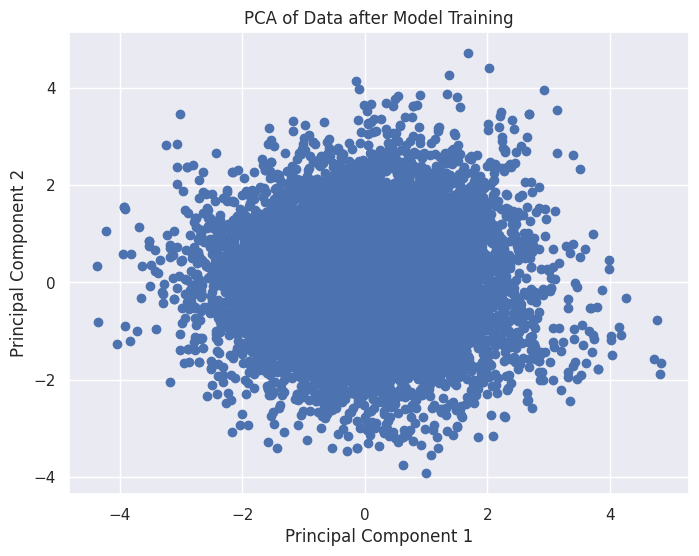

In [112]:
from sklearn.decomposition import PCA
import numpy as np

# Получение данных для визуализации
data_to_visualize = np.ascontiguousarray(train_transform).astype('float32')

# Применение PCA для снижения размерности данных до 2 компонент
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_to_visualize)

# Визуализация данных с помощью scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(data_pca[:, 0], data_pca[:, 1], cmap='viridis')
plt.title('PCA of Data after Model Training')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

На изображении представлена диаграмма рассеяния результатов метода главных компонент (PCA). PCA используется для уменьшения размерности набора данных, сохраняя при этом как можно больше информации. На графике оси обозначены как "Principal Component 1" и "Principal Component 2", что соответствует первой и второй главным компонентам соответственно.

Точки на диаграмме рассеяния представляют индивидуальные наблюдения в новом пространстве, созданном PCA, где каждая ось представляет собой одну из главных компонент, а координаты точки соответствуют значениям по этим компонентам. Распределение точек дает представление об общей структуре набора данных после применения PCA.

Исходя из того, что скопления точек не выделены разными цветами или маркерами, может быть сложно сделать однозначные выводы о наличии отдельных групп в данных. Однако мы можем заметить следующее:


• Данные кажутся относительно центрированными вокруг начала координат, не показывая явного разделения на кластеры.

• Распределение точек довольно однородно и имеет форму окружности/эллипса, что может свидетельствовать о том, что две главные компоненты имеют схожую долю вариации и что между признаками, вероятно, слабая или отсутствует корреляция.

• Вариация данных вдоль осей главных компонент кажется симметричной, и нет очевидных выбросов, которые сильно бы отклонялись от общего распределения.


In [113]:
pca= PCA()
pca.fit(data_to_visualize)
cumsum = np.cumsum(pca.explained_variance_ratio_)
dim = np.argmax(cumsum >= 0.90) + 1
print('The number of dimensions required to preserve 90% of variance is',dim)

The number of dimensions required to preserve 90% of variance is 57


In [114]:
pca = PCA()
pca.fit(data_to_visualize)
cumsum = np.cumsum(pca.explained_variance_ratio_)
dim = np.argmax(cumsum >= 0.90) + 1

important_features = np.argsort(np.abs(pca.components_), axis=1)[:, -dim:]

print('The number of dimensions required to preserve 90% of variance is', dim)
print('The most important features (indices) are:', important_features)

The number of dimensions required to preserve 90% of variance is 57
The most important features (indices) are: [[49 45 54 ... 12  6 47]
 [28  8 61 ... 18 51 36]
 [18 39 30 ...  6 51 23]
 ...
 [34 45 22 ... 59 41 32]
 [36 23 24 ... 21 32 58]
 [44 45 23 ... 32 21 58]]


<ipython-input-115-014efb77faf5>:3: MatplotlibDeprecationWarning: Passing the emit parameter of set_xlim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  plt.xlim(0,70,1)


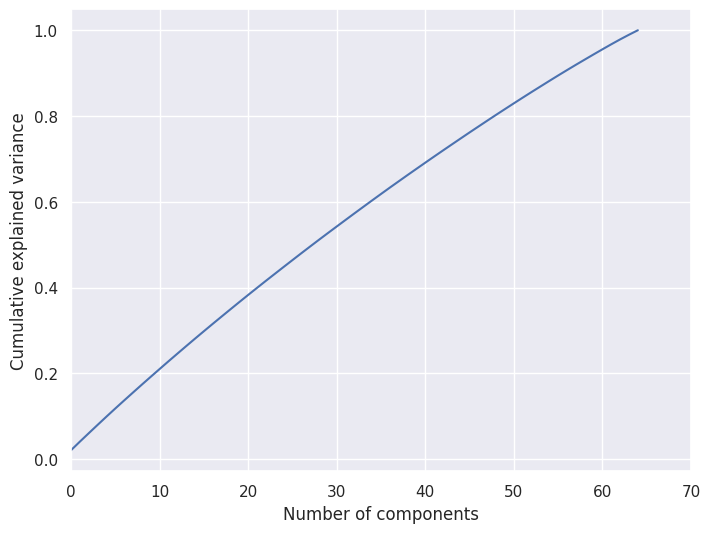

In [115]:
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,70,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

**Выводы:**

Построение и отработка модели производились на уменьшенной выборке. Поскольку значения признаков сильно отличаются друг от друга все признаки были отмасштабированы. Это помогло сделать их равнозначными и находить объективные закономерности в дальнейшем.

Было создано и наполнено векторное пространство из объектов датасета base. Для перебора гиперпараметров использовали OPTUNA. Передали  три гиперпараметра 'n_cells', 'n_probes'. candidate_number по условию равен 5. Получили  лучшие гиперпараметры и далее получили предсказания и метрику на тестовой выборке.

**Итоговое значение целевой метрики 78.67%**, что само по себе неплохо. Были предприняты попытки добавления гиперпараметров 'nbits', но это привело к увеличению времени обучения модели и понижению метрики. Изменение candidate_number в сторону увеличения иакже повышает метрику, но нам была поставлена задача найти только 5 товаров.

**Рекомендации**

**Возможные улучшения:**

1.  при поиске ближайших соседей в качестве меры близости использовать другие варианты, к примеру: IndexFlatIP или IndexIVFPQ
2. Установить большее кол-во кластеров для деления векторного пространства.
3. Попробовать выделить сначала сегмент товаров Accuracy@60 или Accuracy@40, а уж из выбранных сегментов искать необходимые по условию 5 товаров. теоретически это позволит сократить и выборку и время работы модели.
4. Провести анализ важности признаков: Для проведения анализа важности признаков в модели мэтчинга товаров, использующей FAISS, можно воспользоваться различными методами. Один из них — это использование модели, которая может предоставить коэффициенты важности признаков, таких как Random Forest или CatBoost, на предобработанных данных. Далее можно будет интерпретировать результаты и понять, какие признаки оказывают наибольшее влияние на предсказания модели.Исходные данные (большая выборка) имеют хорошее качество.

